## Load Packages

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 100)
import numpy as np
import scipy.stats as ss

## Load Data

In [4]:
data = pd.read_csv('dodgers.csv')

## Data Audit  Part 1

**Missing Values**: Since all columns have 81 non-null values and there were 81 records, I can see the dataset is not missing values.  
**Strange Min/Max Values**: Summary statistics for numerical variables all seemed reasonable.  
**Categorical Variables**: Each column was examined including each unique value for categorical variables. All values were in a standardized format. The numerical columns were all integers. The binary columns were all 'YES' or 'NO'. Months were all capitalized. Values did not contain spelling errors that would cause duplicate unique values.  
**Cardinality**: The opponent variable had the most cardinality, but still only 17 unique values.  
**Infrequent Categorical Values**: The variable cap and shirt only have 2 and 3 respective 'YES' values indicating promotions for these items are very infrequent. Therefore, it will be difficult to estimate their effect on attendence in modeling.  

In [5]:
# Index, columns, non-null counts, datatypes, num rows, num columns, memory
print(data.info())
print("-"*100)

# Summary statistics for numerical columns
print(data.describe())
print("-"*100)

# Unique values and counts for month
print(data.month.value_counts(dropna=False))
print("-"*100)

# Unique values and counts for day_of_week
print(data.day_of_week.value_counts(dropna=False))
print("-"*100)

# Unique values and counts for opponent
print(data.opponent.value_counts(dropna=False))
print("-"*100)

# Unique values and counts for skies
print(data.skies.value_counts(dropna=False))
print("-"*100)

# Unique values and counts for day/night game
print(data.day_night.value_counts(dropna=False))
print("-"*100)

# Unique values and counts for cap promotion
print(data.cap.value_counts(dropna=False))
print("-"*100)

# Unique values and counts for shirt promotion
print(data.shirt.value_counts(dropna=False))
print("-"*100)

# Unique values and counts for fireworks promotion
print(data.fireworks.value_counts(dropna=False))
print("-"*100)

# Unique values and counts for bobblehead promotion
print(data.bobblehead.value_counts(dropna=False))
print("-"*100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   month        81 non-null     object
 1   day          81 non-null     int64 
 2   attend       81 non-null     int64 
 3   day_of_week  81 non-null     object
 4   opponent     81 non-null     object
 5   temp         81 non-null     int64 
 6   skies        81 non-null     object
 7   day_night    81 non-null     object
 8   cap          81 non-null     object
 9   shirt        81 non-null     object
 10  fireworks    81 non-null     object
 11  bobblehead   81 non-null     object
dtypes: int64(3), object(9)
memory usage: 7.7+ KB
None
----------------------------------------------------------------------------------------------------
             day        attend       temp
count  81.000000     81.000000  81.000000
mean   16.135802  41040.074074  73.148148
std     9.605666   8297.539460   8.317318

## Attendence Exploration

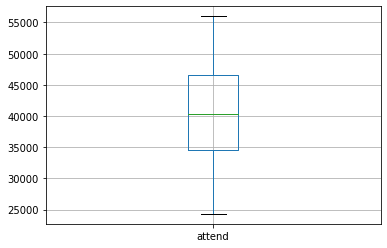

In [6]:
# Boxplot of attendence
data.boxplot(column=['attend'])

Interpretation: Distribution of attendence seems reasonable and values are consistent as each quartile is pretty even in size. This signifies a normal bell shaped distribution.

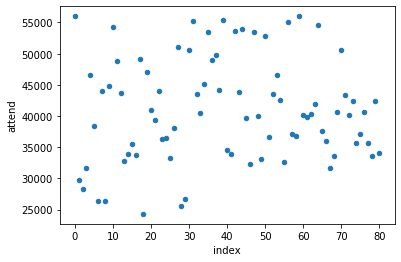

In [7]:
# Distribution of Attendence by index
data.reset_index().plot(kind='scatter', x='index', y='attend')

Interpretation: No outliers

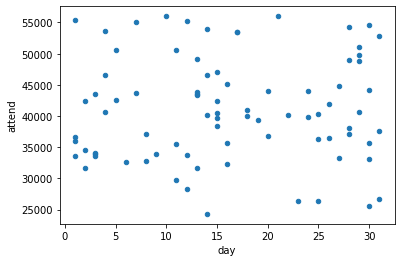

In [8]:
data.plot.scatter(x='day', y='attend')

Interpretation: No linear relation between attendence and day of the month

C:\Users\ssear\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


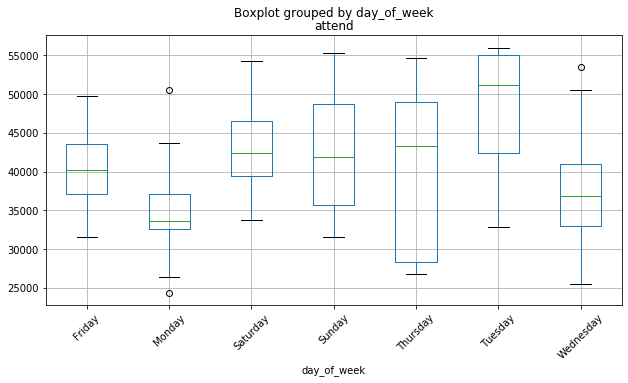

In [9]:
data.boxplot(column=['attend'], by='day_of_week', fontsize = 10, rot=45, figsize=(10,5))

Interpretation: Tuesday seems to have on average higher attendence. I thought this might be just because there were fewer Tuesday games, but Tuesday has as many or more games than the other days. Monday on the other hand is lower on average.

C:\Users\ssear\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


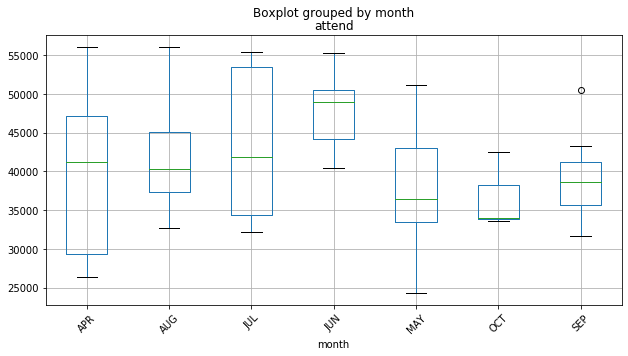

In [10]:
data.boxplot(column=['attend'], by='month', fontsize = 10, rot=45, figsize=(10,5))

Interpretation: June definitely has more attendence on average and the third smallest spread.

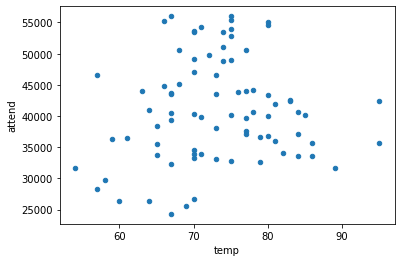

In [11]:
data.plot.scatter(x='temp', y='attend')

Interpretation: No clear relation between attendence and temp. If anything, there is higher attendence in the mid range temperatures from about 65 to 80.

## Data Audit Part 2: Correlations  

**Unusually Strong Correlation between idependent variables and target**: Attendence seems to be most correlated with temperature and day of the week. No independent variables are overwhelmingly predictive however. Further, the relationship between attendence and temp does not appear to be linear as showen in the plot above. Instead it seems to quadratic.  
**Collinearity**: The strongest correlations are between day_of_week-fireworks, day_of_week-day_night, and month-opponent. This makes sense as fireworks are typically on Fridays and Saturdays.

In [12]:
def cramers_v(x, y):
    """Source: https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
    Takes two arrays and returns value between 0 and 1 where 1 represents full association and 0
    represents no association"""
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [13]:
# Test to make sure this function is working as expected
cramers_v(data.attend, data.attend)

0.9999999999999856

In [14]:
# Examining correlation between all variables

correlation_values = []
variable_1 = []
variable_2 = []

for i in range(len(data.columns)):
    for j in range(i+1, len(data.columns)):
        correlation_values.append(cramers_v(data[data.columns[i]], data[data.columns[j]]))
        variable_1.append(data.columns[i])
        variable_2.append(data.columns[j])
        
correlations = pd.DataFrame({'Variable 1':variable_1, 'Variable 2': variable_2, 'Correlation': correlation_values})
correlations.sort_values(by=['Correlation'], ascending=False)

,Variable 1,Variable 2,Correlation
36,day_of_week,fireworks,0.925499
33,day_of_week,day_night,0.710946
3,month,opponent,0.617294
23,attend,temp,0.497734
45,temp,skies,0.467964
39,opponent,skies,0.437246
37,day_of_week,bobblehead,0.431402
41,opponent,cap,0.343409
4,month,temp,0.338835
5,month,skies,0.306877


In [15]:
# Examining correlation between target variable (attendence) and independent variables

correlation_values = []
variable_1 = []
variable_2 = []

for i in range(len(data.columns)):
    correlation_values.append(cramers_v(data.attend, data[data.columns[i]]))
    variable_1.append('attend')
    variable_2.append(data.columns[i])
        
correlations = pd.DataFrame({'Variable 1':variable_1, 'Variable 2': variable_2, 'Correlation': correlation_values})
correlations.sort_values(by=['Correlation'], ascending=False)

,Variable 1,Variable 2,Correlation
2,attend,attend,1.000000
5,attend,temp,0.497734
3,attend,day_of_week,0.275589
6,attend,skies,0.112509
9,attend,shirt,0.112509
10,attend,fireworks,0.112509
8,attend,cap,0.112509
0,attend,month,0.000000
1,attend,day,0.000000
4,attend,opponent,0.000000


# Is attendence higher when there is a promotion?

Below I will convert the Yes/No columns to 0 and 1 so I can calculate correlation with attendence since correlation requires numerical variables. Further, I can introduce a new column for number of promotions. Then I could figure out if the presence of any promotion, regardless of which one, has a correlation with attendence.

In [16]:
data.cap = data.cap.map(dict(YES=1, NO=0))
data.shirt = data.shirt.map(dict(YES=1, NO=0))
data.fireworks = data.fireworks.map(dict(YES=1, NO=0))
data.bobblehead = data.bobblehead.map(dict(YES=1, NO=0))

In [17]:
data['promotions'] = data.cap + data.shirt + data.fireworks + data.bobblehead
data.head()

,month,day,attend,day_of_week,opponent,temp,skies,day_night,cap,shirt,fireworks,bobblehead,promotions
0,APR,10,56000,Tuesday,Pirates,67,Clear,Day,0,0,0,0,0
1,APR,11,29729,Wednesday,Pirates,58,Cloudy,Night,0,0,0,0,0
2,APR,12,28328,Thursday,Pirates,57,Cloudy,Night,0,0,0,0,0
3,APR,13,31601,Friday,Padres,54,Cloudy,Night,0,0,1,0,1
4,APR,14,46549,Saturday,Padres,57,Cloudy,Night,0,0,0,0,0


In [18]:
# Unique values and counts for promotions
print(data.promotions.value_counts(dropna=False))

0    51
1    30
Name: promotions, dtype: int64


Interpretation: 30 of the 81 games had some sort of promotion. This is the number of data points we have to work with to determine if the promotions had an effect.

In [19]:
data.corr()

,day,attend,temp,cap,shirt,fireworks,bobblehead,promotions
day,1.000000,0.027093,-0.127612,-0.202274,-0.030182,0.099528,0.145363,0.104247
attend,0.027093,1.000000,0.098951,-0.055002,0.133269,0.002094,0.581895,0.448887
temp,-0.127612,0.098951,1.000000,0.064521,0.004394,-0.189899,0.049573,-0.091069
cap,-0.202274,-0.055002,0.064521,1.000000,-0.031204,-0.072732,-0.063074,0.207456
shirt,-0.030182,0.133269,0.004394,-0.031204,1.000000,-0.089648,-0.077743,0.255704
fireworks,0.099528,0.002094,-0.189899,-0.072732,-0.089648,1.000000,-0.181207,0.596007
bobblehead,0.145363,0.581895,0.049573,-0.063074,-0.077743,-0.181207,1.000000,0.516859
promotions,0.104247,0.448887,-0.091069,0.207456,0.255704,0.596007,0.516859,1.000000


Interpretation: Using this correlation matrix, we see slightly different results than cramers_v above. Using a binary representation of the promotions, we can see that there is slight correlation between promotions and the attendence. The highest correlation for our target variable, attend, the bobblehead promotion with 0.58 signifying moderate correlation. Overall, however, we can say that there does tend to be higher attendence when there is a promotion, particularly when there are bobblehead promotions. This is illustrated in the box plots below.

C:\Users\ssear\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


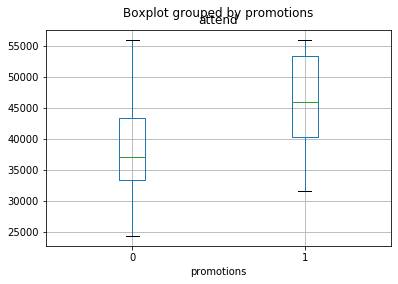

In [20]:
data.boxplot(column=['attend'], by='promotions')

C:\Users\ssear\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


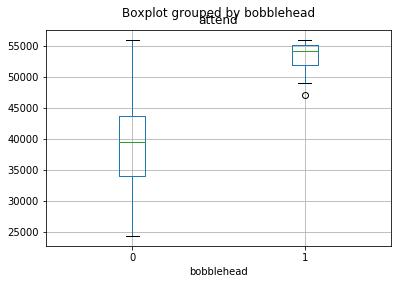

In [21]:
data.boxplot(column=['attend'], by='bobblehead')

C:\Users\ssear\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


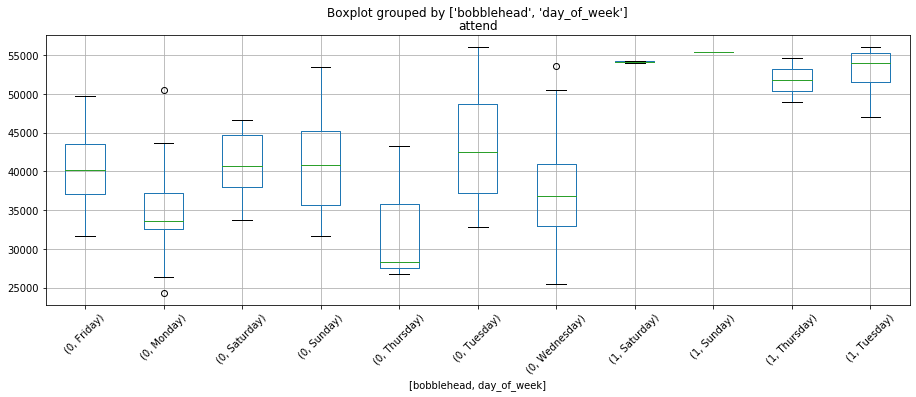

In [22]:
data.boxplot(column=['attend'], by=['bobblehead','day_of_week'], fontsize = 10, rot=45, figsize=(15,5))

In [23]:
# Which day of the week was there a bobblehead promotion
print(data[data.bobblehead==1].day_of_week.value_counts(dropna=False))

Tuesday     6
Thursday    2
Saturday    2
Sunday      1
Name: day_of_week, dtype: int64


Interpretation: We can see from the box plots that each day of the week had higher attendence on average when there was a bobblehead promotion compared to when there wasn't. However, only Tuesday had more than 2 bobblehead promotion records, so it's hard to say for sure that the this is what we would see with a larger data set.

C:\Users\ssear\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


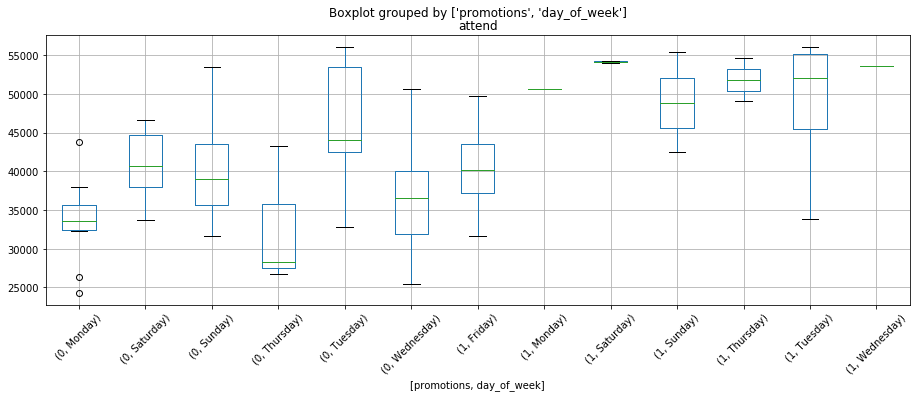

In [24]:
data.boxplot(column=['attend'], by=['promotions','day_of_week'], fontsize = 10, rot=45, figsize=(15,5))

In [25]:
# Which day of the week was there a promotion
print(data[data.promotions==1].day_of_week.value_counts(dropna=False))

Friday       13
Tuesday       8
Sunday        3
Saturday      2
Thursday      2
Wednesday     1
Monday        1
Name: day_of_week, dtype: int64


Comparing simply whether there was a promotion on a certain day of the week or not, we see a trend similar to that of bobbleheads. Looking at Tuesday specifically, the average attendance when there was a promotion is within the IQR of the attendence without a promotion. So that tells us that the increase in attendence with the promotion isn't really an unusually high attendence relative to without a promotion.

In [26]:
data[data.promotions == 1].attend.mean() - data[data.promotions == 0].attend.mean()

7665.288235294116

In [27]:
data[data.bobblehead == 1].attend.mean() - data[data.bobblehead == 0].attend.mean()

14006.707792207788

In [28]:
days = data.day_of_week.unique()
for day in days:
    print(day, data[data.day_of_week == day].attend.mean()-data.attend.mean())


Tuesday 6701.156695156693
Wednesday -3454.9074074074088
Thursday -632.6740740740715
Friday -923.150997150995
Saturday 2032.849002849005
Sunday 1228.772079772083
Monday -6074.407407407409


Interpretation: These calculations say that in this dataset, the attendence was on average 7665 higher when there was a promotion, 14006 higher when that promotion was a bobblehead, and 6701 higher on Tuesdays on average.

In [31]:
# Difference between average attendence for day of week when there was a promotion 
# and average attendence for day of week when there wasn't a promotion

for day in days:
    difference = data[(data.promotions == 1) & (data.day_of_week==day)].attend.mean()\
                - data[(data.promotions == 0)  & (data.day_of_week==day)].attend.mean()
    print('{} - {}'.format(day, difference))

Tuesday - 3224.699999999997
Wednesday - 17438.0
Thursday - 19010.166666666664
Friday - nan
Saturday - 13065.090909090912
Sunday - 8580.199999999997
Monday - 17010.90909090909


In [32]:
# Difference between average attendence for day of week when there was a bobblehead promotion 
# and average attendence for day of week when there wasn't a bobblehead promotion

for day in days:
    difference = data[(data.bobblehead == 1) & (data.day_of_week==day)].attend.mean()\
                - data[(data.bobblehead == 0)  & (data.day_of_week==day)].attend.mean()
    print('{} - {}'.format(day, difference))

Tuesday - 9564.785714285717
Wednesday - nan
Thursday - 19010.166666666664
Friday - nan
Saturday - 13065.090909090912
Sunday - 14181.0
Monday - nan


Interpretation: This shows that the difference the largest effect for both the bobblehead and having a promotion in general comes on Thursday, Saturday, and Sunday. On average, attendence is 19,010 higher on Thursday when there is a bobblehead promotion and 14,181 higher on Sunday when there is a bobblehead promotion. The only issue here is still the small number of records that have this criteria as shown below.

# Feature Creation  

To this point, I have determined that promotions, bobblehead promotions particularly, are associated with differing levels of increased attendence depending on the day of the week. Therefore, I am estimating that promotions, bobblehead, and day of the week will be my predictor variables in my model. The final step for feature creation is to create dummy variables for day of the week.

In [33]:
data = pd.concat([data,pd.get_dummies(data['day_of_week'])],axis=1)

In [35]:
data.corr()

,day,attend,temp,cap,shirt,fireworks,bobblehead,promotions,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
day,1.000000,0.027093,-0.127612,-0.202274,-0.030182,0.099528,0.145363,0.104247,0.145280,-0.118786,0.081861,0.021966,0.179059,-0.094301,-0.162472
attend,0.027093,1.000000,0.098951,-0.055002,0.133269,0.002094,0.581895,0.448887,-0.048948,-0.307198,0.107788,0.065153,-0.019679,0.355316,-0.174723
temp,-0.127612,0.098951,1.000000,0.064521,0.004394,-0.189899,0.049573,-0.091069,-0.182804,-0.015883,-0.024113,0.264787,-0.023216,-0.020044,-0.007474
cap,-0.202274,-0.055002,0.064521,1.000000,-0.031204,-0.072732,-0.063074,0.207456,-0.069569,-0.066354,-0.069569,0.147166,-0.040811,0.147166,-0.066354
shirt,-0.030182,0.133269,0.004394,-0.031204,1.000000,-0.089648,-0.077743,0.255704,-0.085749,0.102233,-0.085749,0.092345,-0.050303,0.092345,-0.081786
fireworks,0.099528,0.002094,-0.189899,-0.072732,-0.089648,1.000000,-0.181207,0.596007,0.956512,-0.190631,-0.199868,-0.199868,-0.117248,-0.199868,-0.098719
bobblehead,0.145363,0.581895,0.049573,-0.063074,-0.077743,-0.181207,1.000000,0.516859,-0.173326,-0.165315,0.023029,-0.075148,0.197809,0.415741,-0.165315
promotions,0.104247,0.448887,-0.091069,0.207456,0.255704,0.596007,0.516859,1.000000,0.570088,-0.247881,-0.196048,-0.126400,0.015738,0.221844,-0.247881
Friday,0.145280,-0.048948,-0.182804,-0.069569,-0.085749,0.956512,-0.173326,0.570088,1.000000,-0.182341,-0.191176,-0.191176,-0.112149,-0.191176,-0.182341
Monday,-0.118786,-0.307198,-0.015883,-0.066354,0.102233,-0.190631,-0.165315,-0.247881,-0.182341,1.000000,-0.182341,-0.182341,-0.106966,-0.182341,-0.173913


From this correlation matrix, the largest positive correlation for day of week and attendence was Tuesday with 0.355.

C:\Users\ssear\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


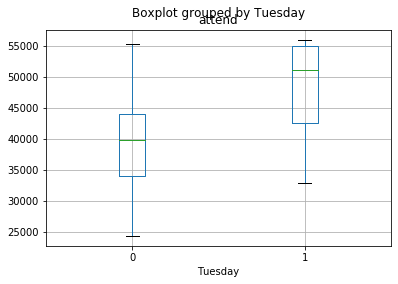

In [36]:
data.boxplot(column=['attend'], by='Tuesday')

Similar to box plots above, this can help to visualize how there could be a positive linear relationship between whether or not the day was Tuesday and the attendence.

# Final Thoughts Prior to Modeling  

I can see that Tuesdays and Bobblehead promotions have the most association with higher attendence. However, if we are wanting to increase attendence using a promotion, it might not make sense to have the promotion on Tuesday because the effect wouldn't be as great. If we are wanting to manufacture more attendence using a promotion, Thursday seems to do that the most. However, this is just from comparing 2 games where there was a promotion to 3 games where there wasn't a promotion on Thursday.

# Export

In [38]:
data.to_csv('dodgers_data_for_modeling.csv', index=False)